# Ensemble Learning

- It is an advanced machine learning technique where multiple models/algorithms are combines to improve the accuracy and robustness of the predictions.
- The main idea here is to leverage the strengths of individual models and reduce their weaknesses by combining their prediction.
- There are three main methods:
    - **Bagging** (short for Bootstrap Aggregation)
        - It works by training multiple copies of the same model on different subsets fo the training data.
        - This is done by sampling the training data with replacement and oversampling, which means some data is actual and some is synthetic.
        - The architecture is parallel
    - **Boosting**
        - It works by training multiple models sequentially 
        - Each model focuses on learning from the previous model's errors (boosting accuracy)
        - The architecture is sequential
        - Steps:
            1. Model 1 trains on 800 records
            2. Model 1 makes errors (100 records)
            3. Weight adjustment: important step. this is where the algo assigns weights for each record. The misclassified records/errors have higher weight values than the accurate predictions 
            4. Model 2 focuses on the 100 records with high weight values to work on fixing the errors from the previous model. 
            5. Let's say it fixed 50, so we have 50 errors left
            6. Model 4 focuses on the 50 records with high weight
        - The errors with the lowest confidence get the highest wait. It's like telling the subsequent model "Hey - pay more attention to these challenging data points"
    - **Stacking**
        - It's the most complex of ensemble learning
        - It allows combining multiple different models/algorithms (base learners)
        - The output of the base models is combined to make up teh training data for the final model (meta model)

![BaggingBoosting](https://miro.medium.com/v2/resize:fit:1100/format:webp/1*zTgGBTQIMlASWm5QuS2UpA.jpeg)

## Bagging

![bg](https://media.geeksforgeeks.org/wp-content/uploads/20210707140912/Bagging.png)

Although we can take a Random Forest Model out-of-the-box, we can also build it from scratch.

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler

In [3]:
data_url = 'http://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv'

col_names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'diabetes']

In [4]:
df =pd.read_csv(data_url, names=col_names)
df.head()

,preg,plas,pres,skin,test,mass,pedi,age,diabetes
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [5]:
df.shape

(768, 9)

### Prep The Data

In [6]:
X = df.drop(columns='diabetes', axis=1)
y = df['diabetes']

In [7]:
scaler = MinMaxScaler()

X_scaled = scaler.fit_transform(X)

> We typically need to spend ample time on EDA and Feature Engineering, but we skipped them this time since we've done enough examples before and for time constraints. 

### Cross-Validation and Model Definition

In [8]:
kfold = KFold(n_splits=10)

In [9]:
dtc_model = DecisionTreeClassifier() #using standard/default hyperparameters

#hyperparameter for the ensemble model
num_trees = 100

### Deploy The Bagging Classifier with Cross-Validation

In [10]:
bc_model = BaggingClassifier(estimator=dtc_model, n_estimators=num_trees, random_state=12)

In [11]:
# deploy cross-validation
results = cross_val_score(bc_model, X_scaled, y, cv=kfold)

In [12]:
results

array([0.66233766, 0.84415584, 0.74025974, 0.67532468, 0.77922078,
       0.83116883, 0.83116883, 0.81818182, 0.71052632, 0.78947368])

In [13]:
len(results)

10

- Every score above represents a fold fit operation. Therefore, we have 10 scores.
- To get the overall outcome, we take the average score

In [14]:
print(f'Overall Accuracy from Cross-Validation: {results.mean():.2f}')

Overall Accuracy from Cross-Validation: 0.77


- You can choose any type of estimator (algorithm) for `BaggingClassifier`
- Recommended models for Ensemble Bagging:
    - Decision Trees
    - Logistic Regression
    - SVC
    - kNN

## Boosting

![seq](https://media.geeksforgeeks.org/wp-content/uploads/20210707140911/Boosting.png)

In [15]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate

> GradientBoostingClassifier uses Decision Trees only

### Model and KFold Process Definition

In [16]:
gbc_model = GradientBoostingClassifier(n_estimators=num_trees, max_depth=3)

In [17]:
kfold = StratifiedKFold(n_splits=8, random_state=20, shuffle=True) #shuffle shuffles the data before randomly splitting

In [18]:
results = cross_validate(gbc_model, X_scaled, y, scoring=('accuracy','f1_weighted'), cv=kfold)

In [19]:
results

{'fit_time': array([0.09670305, 0.09520483, 0.09306216, 0.09227109, 0.0925262 ,
        0.09172487, 0.09065795, 0.09202194]),
 'score_time': array([0.0014801 , 0.00174904, 0.00135994, 0.00147986, 0.00161886,
        0.00139499, 0.00136995, 0.00140095]),
 'test_accuracy': array([0.76041667, 0.76041667, 0.70833333, 0.76041667, 0.75      ,
        0.71875   , 0.8125    , 0.80208333]),
 'test_f1_weighted': array([0.76117886, 0.74346937, 0.7009512 , 0.75555248, 0.74804688,
        0.71769382, 0.80933623, 0.79967239])}

In [20]:
results['test_accuracy'].mean()

0.7591145833333333

In [21]:
results['test_f1_weighted'].mean()

0.7544876524063028

### Hyperparameter Tuning with Ensemble Methods (e.g. Bagging)

In [23]:
from sklearn.model_selection import GridSearchCV

1. Define The Base Learner

In [26]:
dtc_estimator = DecisionTreeClassifier(random_state=10)

2. Define The Hyperparameter Grid

In [36]:


param_grid = {
    # ensemble model hyperparameters
    'n_estimators' : [50, 100, 150], #number of trees
    'max_samples': [0.5,0.7,1], #The number of samples to draw from X to train each base estimator 
    'max_features': [0.5,0.7,1], #The number of features to draw from X to train each base estimator (could be helpful if some features may cause overfitting or noise)
    # base learner hyperparameters
    'estimator__max_depth': [None, 5, 10], #The base estimator's max depth (of each decision tree)
    'estimator__min_samples_split': [2,5,10] #The base estimator's min sample split 
}

3. Define The Bagging Classifier with The Base Learner

In [37]:
bc_model = BaggingClassifier(estimator=dtc_estimator, random_state=10)

4. Perform The `GridSearchCV()`

In [38]:
gs_model = GridSearchCV(estimator=bc_model, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1)

In [39]:
gs_model.fit(X_scaled, y)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


GridSearchCV(cv=5,
             estimator=BaggingClassifier(estimator=DecisionTreeClassifier(random_state=10),
                                         random_state=10),
             param_grid={'estimator__max_depth': [None, 5, 10],
                         'estimator__min_samples_split': [2, 5, 10],
                         'max_features': [0.5, 0.7, 1],
                         'max_samples': [0.5, 0.7, 1],
                         'n_estimators': [50, 100, 150]},
             scoring='accuracy', verbose=1)

In [40]:
print(f'Best Hyperparameters: {gs_model.best_params_}')
print(f'Best Score: {gs_model.best_score_}')

Best Hyperparameters: {'estimator__max_depth': 10, 'estimator__min_samples_split': 2, 'max_features': 0.5, 'max_samples': 0.7, 'n_estimators': 100}
Best Score: 0.7812324929971989


## AUC - ROC Curve

- AUC: Area Under The Curve | ROC: Receiver Operating Characteristic Curve
- AUC-ROC is a widely used evaluation method mainly for binary classification.
- It plots a graph to measure how well a ML model can classify data
- It's also used for comparing the performance of multiple models
- We have 2 axes:
    - TPR: True Positive Rate (y-axis)
    - FPR: False Positive Rate (x-axis)

![auc](https://miro.medium.com/v2/resize:fit:1358/1*Bgc9QOjhnL70g2SQxyj6hQ.png)

**Exercise** Using the diabetes data, build a process that deploys 4 different ensemble learning models and evaluates the best model based on AUC-ROC curve. 

In [45]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_predict

plt.style.use('ggplot')

1. Define multiple ensemble ML algorithms and the cross-validation method

In [42]:
models = {
    #Bagging
    'BaggingkNN': BaggingClassifier(estimator=KNeighborsClassifier(), n_estimators=100),
    'RandomForest': RandomForestClassifier(n_estimators=100),

    #Boosting
    'AdaBoost': AdaBoostClassifier(estimator=DecisionTreeClassifier(), n_estimators=100),
    'GradientBoosting': GradientBoostingClassifier(n_estimators=100)
}

In [43]:
kfold = StratifiedKFold(n_splits=8, shuffle=True, random_state=12)

2. Automate training the model, cross-validation, and plotting

BaggingkNN: AUC-ROC = 0.7906417910447762
RandomForest: AUC-ROC = 0.82769776119403
AdaBoost: AUC-ROC = 0.656044776119403
GradientBoosting: AUC-ROC = 0.836365671641791


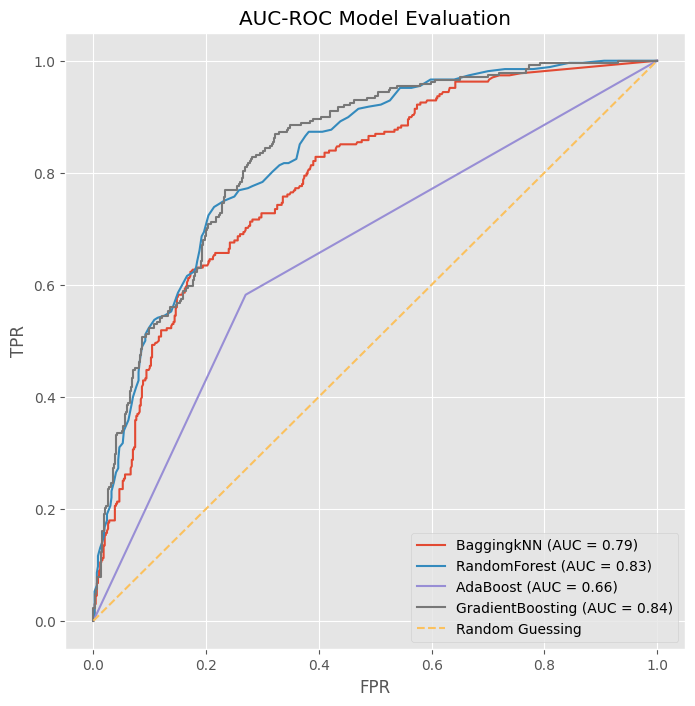

In [48]:
plt.figure(figsize=(8,8))

for name, model in models.items():
    #cross validation training and prediction with probability 
    y_pred_proba = cross_val_predict(model, X_scaled, y, cv=kfold, method='predict_proba')[:,1] #make sure you get the first col of the output

    # calculate the auc score and curve
    auc = roc_auc_score(y, y_pred_proba)
    print(f'{name}: AUC-ROC = {auc}') 

    # false positive and true positive rates
    fpr, tpr, thresh = roc_curve(y, y_pred_proba)

    #plot the curver for each model
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.2f})')

# customize the graph
# plot the diagonal line
plt.plot([0,1], [0,1], linestyle='--', label='Random Guessing')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('AUC-ROC Model Evaluation')
plt.legend()

**Observation**
- AdaBoost model performed the worst (the closest one to random guessing)
- Gradient Boosting performed the best (very close to the top left corner and highest AUC)
- Other models were very close